#Task 1 (5 marks)

* Import Libraries
* Load the images
* Separate the Input and Target Features of the images
* Split the data into Train and Test Sets
* Scale your data if required

## Import libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import json
import kagglehub
import shutil
import random
from sklearn.model_selection import train_test_split
import random
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix


#Getting rid of Tensorflow CUDA warnings
import os
os.environ ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import warnings
warnings.filterwarnings ('ignore')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import load_img, img_to_array, to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16, ResNet50
print ("tensorflow version is:",tf.__version__)


tensorflow version is: 2.17.1


In [ ]:
# For saving models and histories
import pandas as pd
from google.colab import drive

drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


## Import and Load data
The dataset used in this project is taken from open-source platform, Kaggle. It is created by Paul Timothy Mooney and with the title of Chest X-ray Images (Pneumonia).

https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

In [ ]:
paultimothymooney_chest_xray_pneumonia_path = kagglehub.dataset_download('paultimothymooney/chest-xray-pneumonia')

print('Data source import complete.')

print("Path to dataset files:", paultimothymooney_chest_xray_pneumonia_path)

100%|██████████| 2.29G/2.29G [00:26<00:00, 91.4MB/s]

Extracting files...


Data source import complete.
Path to dataset files: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2


In [ ]:
dataset_dir = '/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2'
for root, dirs, files in os.walk(dataset_dir):
    print(f"Directory: {root}")

Directory: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2
Directory: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray
Directory: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/chest_xray
Directory: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/chest_xray/val
Directory: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/chest_xray/val/PNEUMONIA
Directory: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/chest_xray/val/NORMAL
Directory: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/chest_xray/train
Directory: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/chest_xray/train/PNEUMONIA
Directory: /root/.cache/kagglehub/datasets/paultimothymooney/c

In [ ]:
train_folder = '/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train'
test_folder = '/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/test'
val_folder = '/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/val'

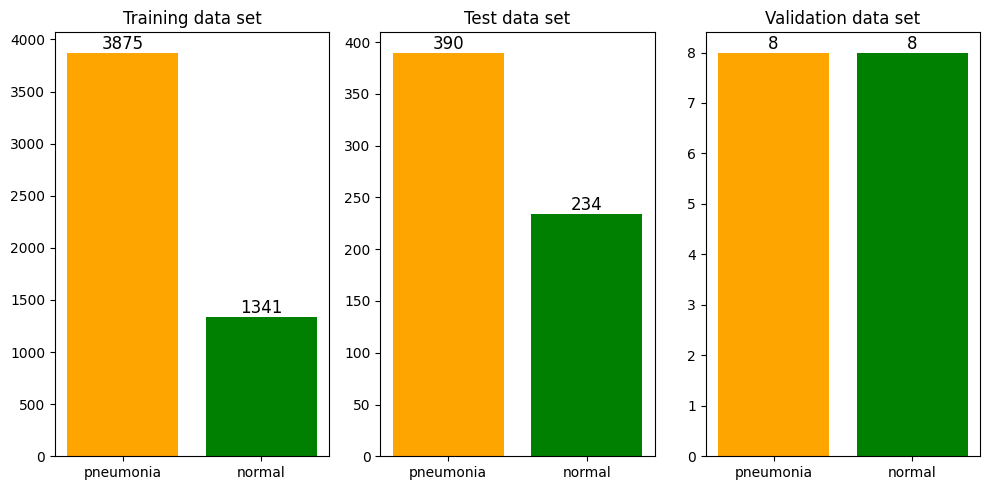

In [ ]:
# Display the dataset's original class distribution
fig = plt.figure(figsize=(10, 5))
c = ['orange', 'green']

def plot_with_values(ax, x, heights, colors, title):
    bars = ax.bar(x, heights, color=colors)
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, yval, int(yval), ha='center', va='bottom', fontsize=12)
    ax.set_title(title)

plt.subplot(1, 3, 1)
plot_with_values(plt.gca(),
                 ["pneumonia", "normal"],
                 [len(os.listdir(train_folder + "/PNEUMONIA")), len(os.listdir(train_folder + "/NORMAL"))],
                 c,
                 "Training data set")
plt.subplot(1, 3, 2)
plot_with_values(plt.gca(),
                 ["pneumonia", "normal"],
                 [len(os.listdir(test_folder + "/PNEUMONIA")), len(os.listdir(test_folder + "/NORMAL"))],
                 c,
                 "Test data set")
plt.subplot(1, 3, 3)
plot_with_values(plt.gca(),
                 ["pneumonia", "normal"],
                 [len(os.listdir(val_folder + "/PNEUMONIA")), len(os.listdir(val_folder + "/NORMAL"))],
                 c,
                 "Validation data set")
plt.tight_layout()
plt.show()

The data appears to be imbalanced along with poor splitting ratios. This could lead to issues such as bias toward the majority class, overfitting or underfitting, and inaccurate evaluation metrics during model training. The model may also perform poorly on the minority class and become biased toward the majority class. Next, prepare the dataset by ensuring balanced class representation across the training, validation and testing splits.

## Data preparation, preprocessing and visualization

### Data Augmentation, Data Partitioning

In [ ]:
# Combine all original data into pneumonia class and normal class
normal_subfolder = 'NORMAL'
pneumonia_subfolder = 'PNEUMONIA'

def get_images_from_folder(folder_path, class_name):
    class_folder = os.path.join(folder_path, class_name)
    images = [os.path.join(class_folder, img) for img in os.listdir(class_folder)]
    return images

normal_train_images = get_images_from_folder(train_folder, normal_subfolder)
pneumonia_train_images = get_images_from_folder(train_folder, pneumonia_subfolder)

normal_test_images = get_images_from_folder(test_folder, normal_subfolder)
pneumonia_test_images = get_images_from_folder(test_folder, pneumonia_subfolder)

normal_val_images = get_images_from_folder(val_folder, normal_subfolder)
pneumonia_val_images = get_images_from_folder(val_folder, pneumonia_subfolder)

# Combined images
all_normal_images = normal_train_images + normal_test_images + normal_val_images
all_pneumonia_images = pneumonia_train_images + pneumonia_test_images + pneumonia_val_images
num_normal_images = len(all_normal_images)
num_pneumonia_images = len(all_pneumonia_images)

print(f"Total number of normal images before selection: {num_normal_images}")
print(f"Total number of pneumonia images before selection: {num_pneumonia_images}")

Total number of normal images before selection: 1583
Total number of pneumonia images before selection: 4273


In [ ]:
# Data augmentation on normal class images
num_images_to_generate = num_pneumonia_images - num_normal_images

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='reflect'
)

target_size = (224, 224)

augmented_dir = '/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/new/augmented'  # Replace with your desired path
os.makedirs(augmented_dir, exist_ok=True)
batch_size = 32
augmented_images = []

for i in range(0, len(all_normal_images), batch_size):
    batch = all_normal_images[i:i+batch_size]
    batch_images = [img_to_array(load_img(img).resize(target_size)) for img in batch]
    batch_images = np.array(batch_images)

    for batch_aug in datagen.flow(batch_images, batch_size=batch_size, shuffle=True, save_to_dir=augmented_dir, save_format='jpeg'):
        augmented_filenames = os.listdir(augmented_dir)
        for filename in augmented_filenames[-batch_size:]:
            augmented_images.append(os.path.join(augmented_dir, filename))
        break

    if len(augmented_images) >= num_images_to_generate:
        break

all_normal_images.extend(augmented_images)

print("Data augmentation on normal class images completed.")

Data augmentation on normal class images completed.


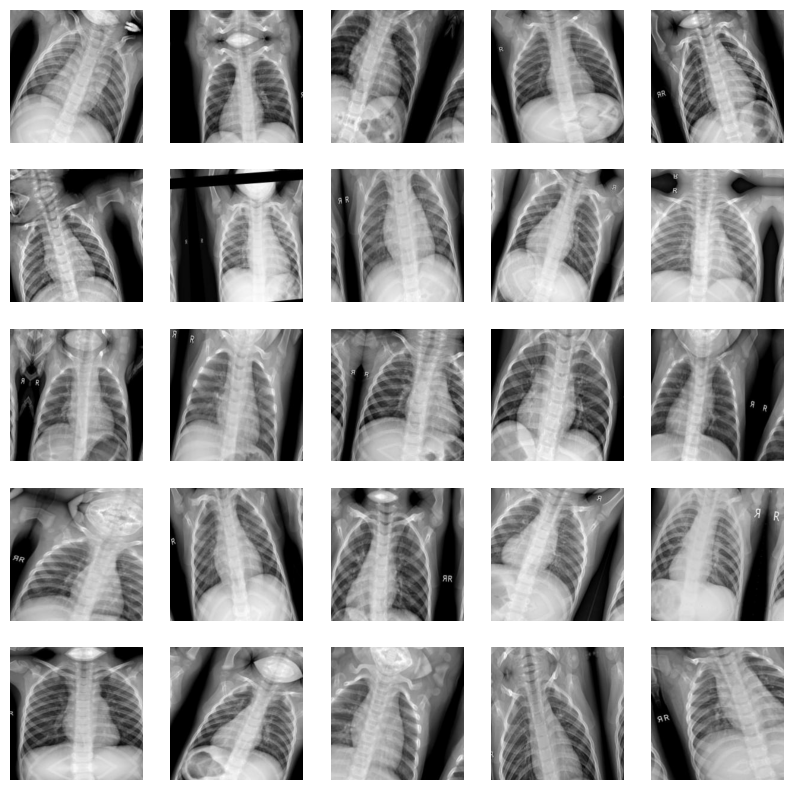

In [ ]:
# Display augmented images
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    img = plt.imread(augmented_images[i])
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [ ]:
print(f"Total number of normal images after selection: {len(all_normal_images)}")
print(f"Total number of pneumonia images after selection: {len(all_pneumonia_images)}")

Total number of normal images after selection: 3183
Total number of pneumonia images after selection: 4273


In [ ]:
# Split combined images in new ratio (8:1:1)
selected_normal_images = random.sample(all_normal_images, 3000)
selected_pneumonia_images = random.sample(all_pneumonia_images, 3000)

selected_images = selected_normal_images + selected_pneumonia_images
labels = ['NORMAL'] * 3000 + ['PNEUMONIA'] * 3000

combined = list(zip(selected_images, labels))
random.shuffle(combined)
selected_images, labels = zip(*combined)

train_images, temp_images, train_labels, temp_labels = train_test_split(
    selected_images, labels, test_size=0.2, random_state=42, shuffle=True)
val_images, test_images, val_labels, test_labels = train_test_split(
    temp_images, temp_labels, test_size=0.5, random_state=42, shuffle=True)

In [ ]:
# Display the class distribution on each set after split
def print_label_distribution(labels, set_name):
    normal_count = labels.count('NORMAL')
    pneumonia_count = labels.count('PNEUMONIA')
    print(f"  NORMAL: {normal_count}")
    print(f"  PNEUMONIA: {pneumonia_count}")

print(f"Train set: {len(train_images)} images")
print_label_distribution(train_labels, "Train set")
print("-" * 30)
print(f"Validation set: {len(val_images)} images")
print_label_distribution(val_labels, "Validation set")
print("-" * 30)
print(f"Test set: {len(test_images)} images")
print_label_distribution(test_labels, "Test set")

Train set: 4800 images
  NORMAL: 2417
  PNEUMONIA: 2383
------------------------------
Validation set: 600 images
  NORMAL: 298
  PNEUMONIA: 302
------------------------------
Test set: 600 images
  NORMAL: 285
  PNEUMONIA: 315


In [ ]:
# Move to new directory
new_base_dir = '/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/new'
train_new_dir = os.path.join(new_base_dir, 'train')
val_new_dir = os.path.join(new_base_dir, 'val')
test_new_dir = os.path.join(new_base_dir, 'test')

def remove_existing_directory(dir_path):
    if os.path.exists(dir_path):
        shutil.rmtree(dir_path)

remove_existing_directory(train_new_dir)
remove_existing_directory(val_new_dir)
remove_existing_directory(test_new_dir)

os.makedirs(train_new_dir, exist_ok=True)
os.makedirs(val_new_dir, exist_ok=True)
os.makedirs(test_new_dir, exist_ok=True)

def move_images_to_new_dir(images, labels, dest_folder):
    for img, label in zip(images, labels):
        class_folder = os.path.join(dest_folder, label)

        if not os.path.exists(class_folder):
            os.makedirs(class_folder)

        img_name = os.path.basename(img)
        dest_path = os.path.join(class_folder, img_name)

        if os.path.exists(dest_path):
            base_name, ext = os.path.splitext(img_name)
            counter = 1
            while os.path.exists(dest_path):
                new_img_name = f"{base_name}_{counter}{ext}"
                dest_path = os.path.join(class_folder, new_img_name)
                counter += 1
        else:
            new_img_name = img_name

        shutil.copy(img, dest_path)

move_images_to_new_dir(train_images, train_labels, train_new_dir)
move_images_to_new_dir(val_images, val_labels, val_new_dir)
move_images_to_new_dir(test_images, test_labels, test_new_dir)

print("Data successfully split and moved into the new directories!")


Data successfully split and moved into the new directories!


In [ ]:
new_train_folder = '/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/new/train'
new_validate_folder = '/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/new/val'
new_test_folder = '/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/new/test'

In [ ]:
folders = {
    "train": new_train_folder,
    "val": new_validate_folder,
    "test": new_test_folder
}

labels = ["NORMAL", "PNEUMONIA"]

def get_class_counts(base_dir):
    class_counts = {}
    for label in labels:
        class_folder = os.path.join(base_dir, label)
        if os.path.exists(class_folder):
            class_counts[label] = len([f for f in os.listdir(class_folder) if os.path.isfile(os.path.join(class_folder, f))])
        else:
            class_counts[label] = 0
    return class_counts

for folder_name, folder_path in folders.items():
    print(f"Class distribution in {folder_name} folder:")
    class_counts = get_class_counts(folder_path)
    for label, count in class_counts.items():
        print(f"  {label}: {count} images")
    print("-" * 30)


Class distribution in train folder:
  NORMAL: 2417 images
  PNEUMONIA: 2383 images
------------------------------
Class distribution in val folder:
  NORMAL: 298 images
  PNEUMONIA: 302 images
------------------------------
Class distribution in test folder:
  NORMAL: 285 images
  PNEUMONIA: 315 images
------------------------------


### Data Resizing, Data Scaling, Data Labelling

In [ ]:
labels = ['NORMAL' , 'PNEUMONIA']
img_size = 224
def get_training_data(data_dir):
    images = []
    targets = []

    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)

        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                images.append(resized_arr)
                targets.append(class_num)

            except Exception as e:
                print(f"Error loading image {img}: {e}")

    images = np.array(images)
    targets = np.array(targets)

    images = images.astype('float32') / 255.0
    targets = to_categorical(targets, num_classes=2)

    images, targets = shuffle(images, targets, random_state=42)

    return images, targets

In [ ]:
train_images, train_labels = get_training_data(new_train_folder)
val_images, val_labels = get_training_data(new_validate_folder)
test_images, test_labels = get_training_data(new_test_folder)

### Data visualization

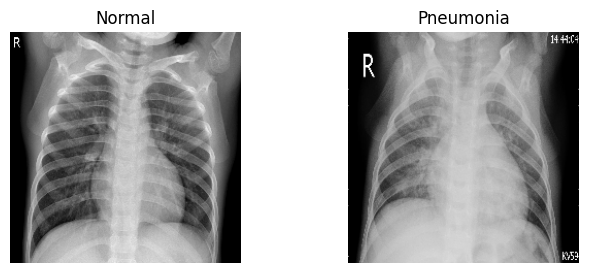

In [ ]:
# Display normal class image and pneumonia class image
normal_images = [train_images[i] for i in range(len(train_labels)) if np.argmax(train_labels[i]) == 0]
pneumonia_images = [train_images[i] for i in range(len(train_labels)) if np.argmax(train_labels[i]) == 1]


if len(normal_images) > 0 and len(pneumonia_images) > 0:
    plt.figure(figsize=(8, 3))

    plt.subplot(1, 2, 1)
    plt.imshow(normal_images[0], cmap='gray')
    plt.axis('off')
    plt.title('Normal')

    plt.subplot(1, 2, 2)
    plt.imshow(pneumonia_images[0], cmap='gray')
    plt.axis('off')
    plt.title('Pneumonia')

    plt.show()

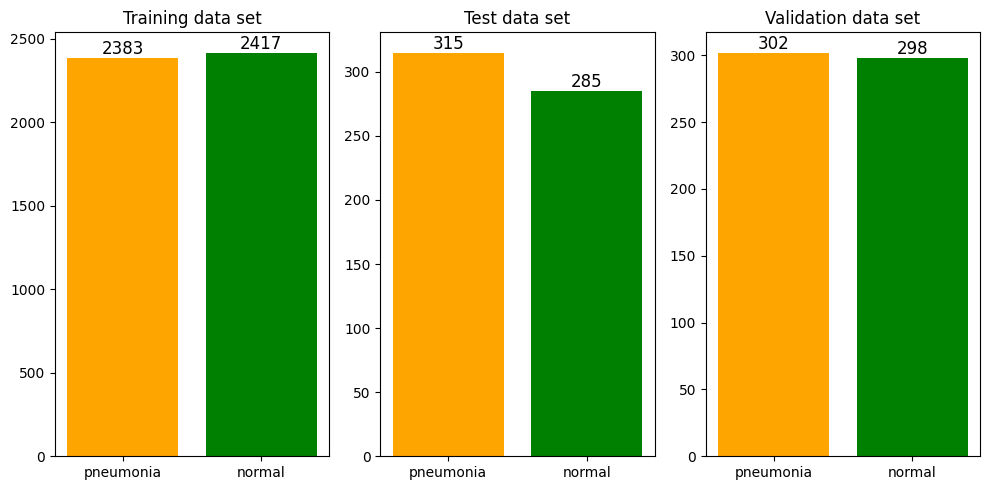

In [ ]:
# Display the class distribution of datasets
fig = plt.figure(figsize=(10, 5))
c = ['orange', 'green']

def plot_with_values(ax, x, heights, colors, title):
    bars = ax.bar(x, heights, color=colors)
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, yval, int(yval), ha='center', va='bottom', fontsize=12)
    ax.set_title(title)

plt.subplot(1, 3, 1)
plot_with_values(plt.gca(),
                 ["pneumonia", "normal"],
                 [len(os.listdir(new_train_folder + "/PNEUMONIA")), len(os.listdir(new_train_folder + "/NORMAL"))],
                 c,
                 "Training data set")
plt.subplot(1, 3, 2)
plot_with_values(plt.gca(),
                 ["pneumonia", "normal"],
                 [len(os.listdir(new_test_folder + "/PNEUMONIA")), len(os.listdir(new_test_folder + "/NORMAL"))],
                 c,
                 "Test data set")
plt.subplot(1, 3, 3)
plot_with_values(plt.gca(),
                 ["pneumonia", "normal"],
                 [len(os.listdir(new_validate_folder + "/PNEUMONIA")), len(os.listdir(new_validate_folder + "/NORMAL"))],
                 c,
                 "Validation data set")
plt.tight_layout()
plt.show()

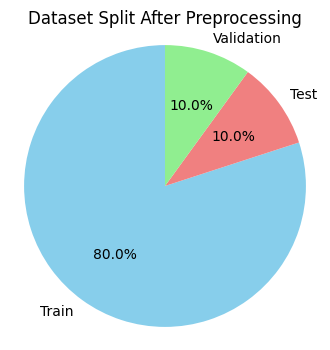

In [ ]:
total_samples = len(train_labels) + len(test_labels) + len(val_labels)
train_samples = len(train_labels)
test_samples = len(test_labels)
val_samples = len(val_labels)

labels = ['Train', 'Test', 'Validation']
sizes = [train_samples, test_samples, val_samples]

plt.figure(figsize=(4, 4))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightcoral', 'lightgreen'])
plt.title("Dataset Split After Preprocessing")
plt.axis('equal')
plt.show()


Now, the data is in a 8:1:1 ratio split.

# Task 2:  (5 marks)
- Train and compare three Machine Learning/Deep Learning Models
- Evaluate the model using F1 Score

## CNN

In [ ]:
# CNN model
cnn_model = Sequential([

    Conv2D(filters = 32, kernel_size = 3, activation = "relu", input_shape = [224,224,3]),
    MaxPool2D(pool_size = 2 , strides = 2),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dense(2, activation='softmax')
  ])


In [ ]:
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 111, 111, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 55, 55, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 55, 55, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 27, 27, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 93312)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,944,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,037,570 (45.92 MB)

 Trainable params: 12,037,570 (45.92 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
learning_rate = 0.0001
AdamOptimizer = Adam(learning_rate=learning_rate)

cnn_model.compile(optimizer=AdamOptimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
cnn_history = cnn_model.fit(
    train_images, train_labels,
    epochs=5,
    batch_size=32,
    validation_data=(val_images, val_labels)
)

Epoch 1/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 19s 79ms/step - accuracy: 0.7580 - loss: 0.4743 - val_accuracy: 0.9217 - val_loss: 0.1876
Epoch 2/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - accuracy: 0.9478 - loss: 0.1521 - val_accuracy: 0.9417 - val_loss: 0.1284
Epoch 3/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - accuracy: 0.9585 - loss: 0.1186 - val_accuracy: 0.9417 - val_loss: 0.1525
Epoch 4/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 8s 55ms/step - accuracy: 0.9619 - loss: 0.1102 - val_accuracy: 0.9583 - val_loss: 0.1199
Epoch 5/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - accuracy: 0.9650 - loss: 0.0955 - val_accuracy: 0.9467 - val_loss: 0.1284


In [ ]:
# Save model and training history
cnn_model.save('/content/drive/MyDrive/XAI-AA/pneumonia_cnn_model.keras')

with open('/content/drive/MyDrive/XAI-AA/cnn_training_history.json', 'w') as f:
    json.dump(cnn_history.history, f)

In [ ]:
# Load CNN model and training history from google drive
loaded_cnn_model = load_model('/content/drive/MyDrive/XAI-AA/pneumonia_cnn_model.keras')

with open('/content/drive/MyDrive/XAI-AA/cnn_training_history.json', 'r') as f:
    loaded_cnn_history = json.load(f)

print(loaded_cnn_history)

{'accuracy': [0.8583333492279053, 0.9468749761581421, 0.950208306312561, 0.9637500047683716, 0.9670833349227905], 'loss': [0.3248484432697296, 0.15177766978740692, 0.13329561054706573, 0.10353811085224152, 0.09185151755809784], 'val_accuracy': [0.92166668176651, 0.9416666626930237, 0.9416666626930237, 0.9583333134651184, 0.9466666579246521], 'val_loss': [0.1875714808702469, 0.12835752964019775, 0.15254099667072296, 0.11988162994384766, 0.1284477263689041]}


In [ ]:
print("Training History:")
print("Training Accuracy:", loaded_cnn_history['accuracy'])
print("Validation Accuracy:", loaded_cnn_history['val_accuracy'])
print("Training Loss:", loaded_cnn_history['loss'])
print("Validation Loss:", loaded_cnn_history['val_loss'])

Training History:
Training Accuracy: [0.8583333492279053, 0.9468749761581421, 0.950208306312561, 0.9637500047683716, 0.9670833349227905]
Validation Accuracy: [0.92166668176651, 0.9416666626930237, 0.9416666626930237, 0.9583333134651184, 0.9466666579246521]
Training Loss: [0.3248484432697296, 0.15177766978740692, 0.13329561054706573, 0.10353811085224152, 0.09185151755809784]
Validation Loss: [0.1875714808702469, 0.12835752964019775, 0.15254099667072296, 0.11988162994384766, 0.1284477263689041]


In [ ]:
test_loss, test_acc = loaded_cnn_model.evaluate(test_images, test_labels,verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")

Test Loss: 0.1491962969303131
Test Accuracy: 0.9566666483879089


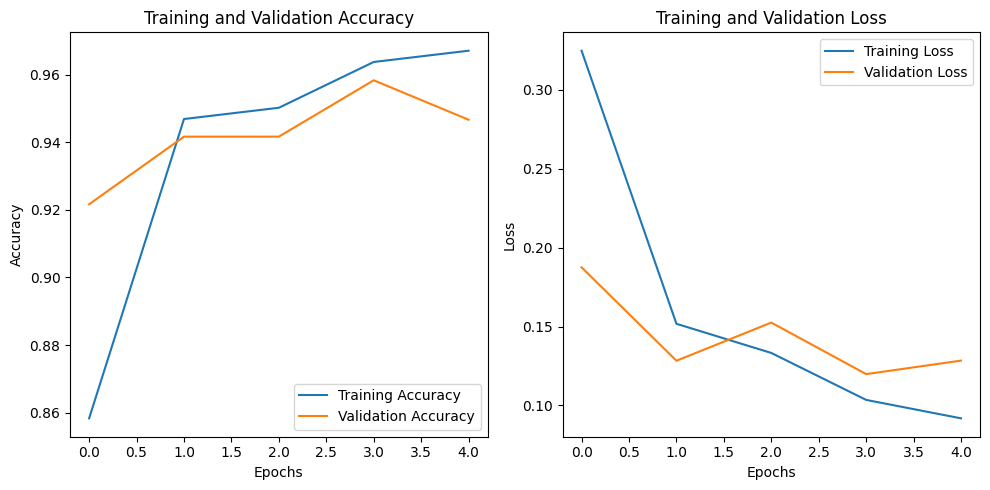

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].plot(loaded_cnn_history['accuracy'], label='Training Accuracy')
axes[0].plot(loaded_cnn_history['val_accuracy'], label='Validation Accuracy')
axes[0].set_title('Training and Validation Accuracy')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend(loc='lower right')

axes[1].plot(loaded_cnn_history['loss'], label='Training Loss')
axes[1].plot(loaded_cnn_history['val_loss'], label='Validation Loss')
axes[1].set_title('Training and Validation Loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend(loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
if len(test_labels.shape) > 1 and test_labels.shape[1] > 1:
    cr_test_labels = np.argmax(test_labels, axis=1)
test_preds = loaded_cnn_model.predict(test_images, verbose=0)
test_preds = np.argmax(test_preds, axis=1)

class_names = ['Normal', 'Pneumonia']

# Display classification report
print(classification_report(cr_test_labels, test_preds, target_names=class_names))


              precision    recall  f1-score   support

      Normal       0.95      0.96      0.95       285
   Pneumonia       0.97      0.95      0.96       315

    accuracy                           0.96       600
   macro avg       0.96      0.96      0.96       600
weighted avg       0.96      0.96      0.96       600



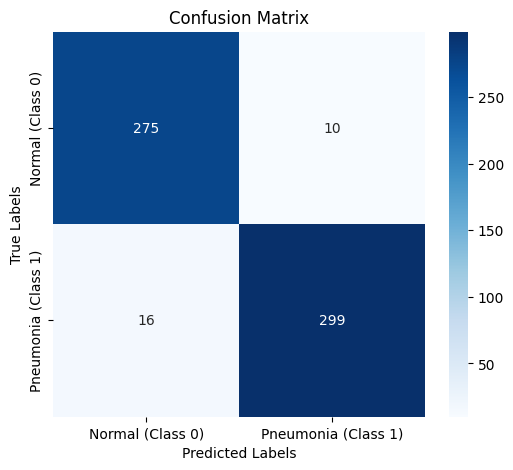

In [ ]:
# Generate confusion matrix
cm = confusion_matrix(cr_test_labels, test_preds)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Normal (Class 0)', 'Pneumonia (Class 1)'],
            yticklabels=['Normal (Class 0)', 'Pneumonia (Class 1)'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## VGG-16

In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=[224, 224, 3])
base_model.trainable = False

vgg16_model = Sequential()
vgg16_model.add(base_model)

vgg16_model.add(Flatten())
vgg16_model.add(Dense(1024, activation='relu'))
vgg16_model.add(Dense(1024, activation='relu'))
vgg16_model.add(Dense(512, activation='relu'))
vgg16_model.add(Dropout(0.5))
vgg16_model.add(Dense(2, activation='softmax'))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
vgg16_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │      25,691,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │           1,026 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 41,981,250 (160.15 MB)

 Trainable params: 27,266,562 (104.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
learning_rate = 0.0001
AdamOptimizer = Adam(learning_rate=learning_rate)

vgg16_model.compile(optimizer=AdamOptimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
vgg16_history = vgg16_model.fit(
    train_images, train_labels,
    epochs=5,
    batch_size=32,
    validation_data=(val_images, val_labels)
)

Epoch 1/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 57s 271ms/step - accuracy: 0.8788 - loss: 0.2741 - val_accuracy: 0.9717 - val_loss: 0.0819
Epoch 2/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 50s 151ms/step - accuracy: 0.9695 - loss: 0.0863 - val_accuracy: 0.9650 - val_loss: 0.0931
Epoch 3/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 41s 154ms/step - accuracy: 0.9789 - loss: 0.0645 - val_accuracy: 0.9450 - val_loss: 0.1446
Epoch 4/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 45s 179ms/step - accuracy: 0.9807 - loss: 0.0628 - val_accuracy: 0.9717 - val_loss: 0.0707
Epoch 5/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 38s 162ms/step - accuracy: 0.9831 - loss: 0.0458 - val_accuracy: 0.9717 - val_loss: 0.0647


In [ ]:
print("Training History:")
print("Training Accuracy:", vgg16_history.history['accuracy'])
print("Validation Accuracy:", vgg16_history.history['val_accuracy'])
print("Training Loss:", vgg16_history.history['loss'])
print("Validation Loss:", vgg16_history.history['val_loss'])

Training History:
Training Accuracy: [0.9258333444595337, 0.965624988079071, 0.9766666889190674, 0.9785416722297668, 0.9818750023841858]
Validation Accuracy: [0.971666693687439, 0.9649999737739563, 0.9449999928474426, 0.971666693687439, 0.971666693687439]
Training Loss: [0.18508578836917877, 0.09378816187381744, 0.06749088317155838, 0.06490099430084229, 0.04734290391206741]
Validation Loss: [0.0818999707698822, 0.09312503784894943, 0.14459432661533356, 0.07067815959453583, 0.0647045448422432]


In [ ]:
# Save model and training history
vgg16_model.save('/content/drive/MyDrive/XAI-AA/pneumonia_vgg16_model.keras')

with open('/content/drive/MyDrive/XAI-AA/vgg16_training_history.json', 'w') as f:
    json.dump(vgg16_history.history, f)

In [ ]:
# Load CNN model and training history from google drive
loaded_vgg16_model = load_model('/content/drive/MyDrive/XAI-AA/pneumonia_vgg16_model.keras')

with open('/content/drive/MyDrive/XAI-AA/vgg16_training_history.json', 'r') as f:
    loaded_vgg16_history = json.load(f)

print(loaded_vgg16_history)

{'accuracy': [0.9258333444595337, 0.965624988079071, 0.9766666889190674, 0.9785416722297668, 0.9818750023841858], 'loss': [0.18508578836917877, 0.09378816187381744, 0.06749088317155838, 0.06490099430084229, 0.04734290391206741], 'val_accuracy': [0.971666693687439, 0.9649999737739563, 0.9449999928474426, 0.971666693687439, 0.971666693687439], 'val_loss': [0.0818999707698822, 0.09312503784894943, 0.14459432661533356, 0.07067815959453583, 0.0647045448422432]}


In [ ]:
print("Training History:")
print("Training Accuracy:", loaded_vgg16_history['accuracy'])
print("Validation Accuracy:", loaded_vgg16_history['val_accuracy'])
print("Training Loss:", loaded_vgg16_history['loss'])
print("Validation Loss:", loaded_vgg16_history['val_loss'])

Training History:
Training Accuracy: [0.9258333444595337, 0.965624988079071, 0.9766666889190674, 0.9785416722297668, 0.9818750023841858]
Validation Accuracy: [0.971666693687439, 0.9649999737739563, 0.9449999928474426, 0.971666693687439, 0.971666693687439]
Training Loss: [0.18508578836917877, 0.09378816187381744, 0.06749088317155838, 0.06490099430084229, 0.04734290391206741]
Validation Loss: [0.0818999707698822, 0.09312503784894943, 0.14459432661533356, 0.07067815959453583, 0.0647045448422432]


In [ ]:
test_loss, test_acc = loaded_vgg16_model.evaluate(test_images, test_labels, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")

Test Loss: 0.05371580645442009
Test Accuracy: 0.9800000190734863


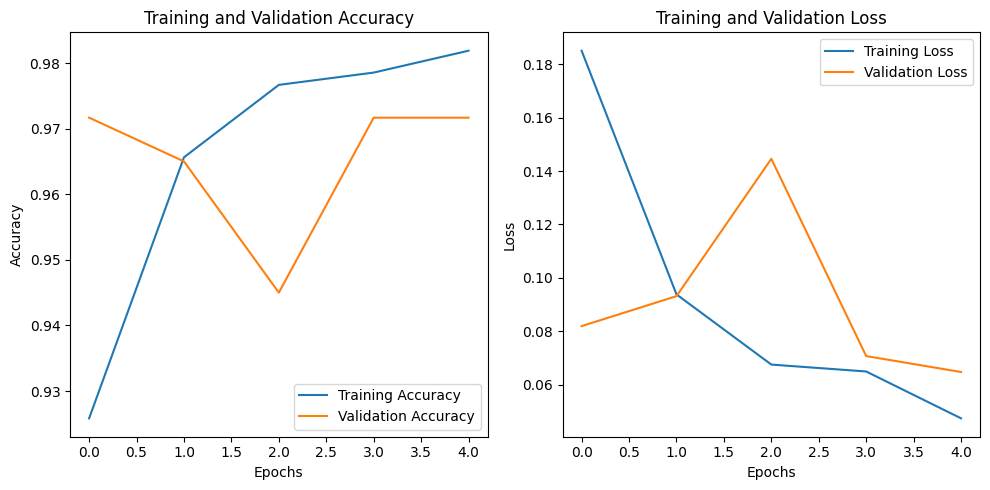

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].plot(loaded_vgg16_history['accuracy'], label='Training Accuracy')
axes[0].plot(loaded_vgg16_history['val_accuracy'], label='Validation Accuracy')
axes[0].set_title('Training and Validation Accuracy')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend(loc='lower right')

axes[1].plot(loaded_vgg16_history['loss'], label='Training Loss')
axes[1].plot(loaded_vgg16_history['val_loss'], label='Validation Loss')
axes[1].set_title('Training and Validation Loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend(loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
if len(test_labels.shape) > 1 and test_labels.shape[1] > 1:
    cr_test_labels = np.argmax(test_labels, axis=1)
test_preds = loaded_vgg16_model.predict(test_images, verbose=0)
test_preds = np.argmax(test_preds, axis=1)

class_names = ['Normal', 'Pneumonia']

# Display classification report
print(classification_report(cr_test_labels, test_preds, target_names=class_names))

              precision    recall  f1-score   support

      Normal       0.98      0.98      0.98       285
   Pneumonia       0.98      0.98      0.98       315

    accuracy                           0.98       600
   macro avg       0.98      0.98      0.98       600
weighted avg       0.98      0.98      0.98       600



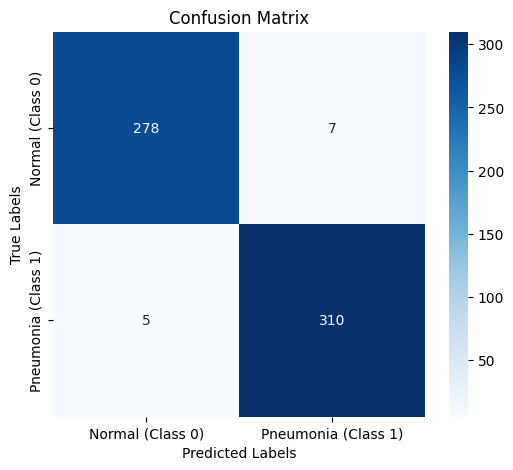

In [ ]:
# Generate confusion matrix
cm = confusion_matrix(cr_test_labels, test_preds)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Normal (Class 0)', 'Pneumonia (Class 1)'],
            yticklabels=['Normal (Class 0)', 'Pneumonia (Class 1)'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## ResNet-50

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=[224, 224, 3])
base_model.trainable = False

resnet50_model = Sequential()
resnet50_model.add(base_model)

resnet50_model.add(Flatten())
resnet50_model.add(Dense(1024, activation='relu'))
resnet50_model.add(Dense(1024, activation='relu'))
resnet50_model.add(Dense(512, activation='relu'))
resnet50_model.add(Dropout(0.5))
resnet50_model.add(Dense(2, activation='softmax'))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
resnet50_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1024)                │     102,761,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 2)                   │           1,026 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 127,924,610 (487.99 MB)

 Trainable params: 104,336,898 (398.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
learning_rate = 0.0001
AdamOptimizer = Adam(learning_rate=learning_rate)

resnet50_model.compile(optimizer=AdamOptimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
resnet50_history = resnet50_model.fit(
    train_images, train_labels,
    epochs=5,
    batch_size=32,
    validation_data=(val_images, val_labels)
)

Epoch 1/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 52s 190ms/step - accuracy: 0.6047 - loss: 0.8104 - val_accuracy: 0.8717 - val_loss: 0.3703
Epoch 2/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 56s 123ms/step - accuracy: 0.8481 - loss: 0.3666 - val_accuracy: 0.9000 - val_loss: 0.2338
Epoch 3/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 20s 121ms/step - accuracy: 0.8782 - loss: 0.2950 - val_accuracy: 0.8917 - val_loss: 0.2996
Epoch 4/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 20s 117ms/step - accuracy: 0.8959 - loss: 0.2635 - val_accuracy: 0.8867 - val_loss: 0.2445
Epoch 5/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 21s 122ms/step - accuracy: 0.9131 - loss: 0.2141 - val_accuracy: 0.8467 - val_loss: 0.3689


In [ ]:
# Save model and training history
resnet50_model.save('/content/drive/MyDrive/XAI-AA/pneumonia_resnet50_model.keras')

with open('/content/drive/MyDrive/XAI-AA/resnet50_training_history.json', 'w') as f:
    json.dump(resnet50_history.history, f)

In [ ]:
# Load CNN model and training history from google drive
loaded_resnet50_model = load_model('/content/drive/MyDrive/XAI-AA/pneumonia_resnet50_model.keras')

with open('/content/drive/MyDrive/XAI-AA/resnet50_training_history.json', 'r') as f:
    loaded_resnet50_history = json.load(f)

print(loaded_resnet50_history)

{'accuracy': [0.6956250071525574, 0.8643749952316284, 0.877916693687439, 0.893750011920929, 0.9129166603088379], 'loss': [0.6159046292304993, 0.3357849717140198, 0.2980242669582367, 0.26404058933258057, 0.218197301030159], 'val_accuracy': [0.871666669845581, 0.8999999761581421, 0.8916666507720947, 0.8866666555404663, 0.846666693687439], 'val_loss': [0.3703411817550659, 0.23377889394760132, 0.2996246814727783, 0.2445015162229538, 0.36893993616104126]}


In [ ]:
print("Training History:")
print("Training Accuracy:", loaded_resnet50_history['accuracy'])
print("Validation Accuracy:", loaded_resnet50_history['val_accuracy'])
print("Training Loss:", loaded_resnet50_history['loss'])
print("Validation Loss:", loaded_resnet50_history['val_loss'])

Training History:
Training Accuracy: [0.6956250071525574, 0.8643749952316284, 0.877916693687439, 0.893750011920929, 0.9129166603088379]
Validation Accuracy: [0.871666669845581, 0.8999999761581421, 0.8916666507720947, 0.8866666555404663, 0.846666693687439]
Training Loss: [0.6159046292304993, 0.3357849717140198, 0.2980242669582367, 0.26404058933258057, 0.218197301030159]
Validation Loss: [0.3703411817550659, 0.23377889394760132, 0.2996246814727783, 0.2445015162229538, 0.36893993616104126]


In [ ]:
test_loss, test_acc = loaded_resnet50_model.evaluate(test_images, test_labels, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")

Test Loss: 0.31784528493881226
Test Accuracy: 0.8700000047683716


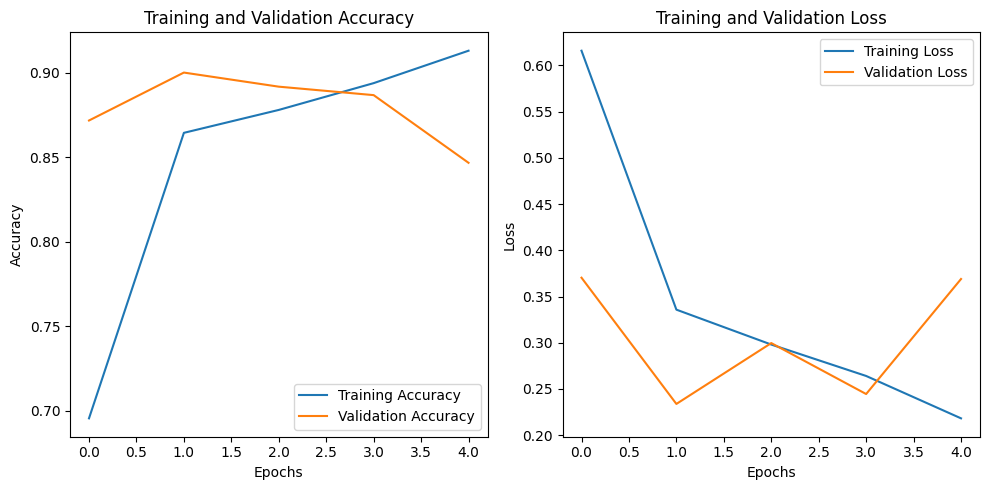

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].plot(loaded_resnet50_history['accuracy'], label='Training Accuracy')
axes[0].plot(loaded_resnet50_history['val_accuracy'], label='Validation Accuracy')
axes[0].set_title('Training and Validation Accuracy')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend(loc='lower right')

axes[1].plot(loaded_resnet50_history['loss'], label='Training Loss')
axes[1].plot(loaded_resnet50_history['val_loss'], label='Validation Loss')
axes[1].set_title('Training and Validation Loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend(loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
if len(test_labels.shape) > 1 and test_labels.shape[1] > 1:
    cr_test_labels = np.argmax(test_labels, axis=1)

test_preds = resnet50_model.predict(test_images, verbose=0)
test_preds = np.argmax(test_preds, axis=1)

class_names = ['Normal', 'Pneumonia']

# Display classification report
print(classification_report(cr_test_labels, test_preds, target_names=class_names))


              precision    recall  f1-score   support

      Normal       0.98      0.74      0.84       285
   Pneumonia       0.81      0.99      0.89       315

    accuracy                           0.87       600
   macro avg       0.89      0.86      0.87       600
weighted avg       0.89      0.87      0.87       600



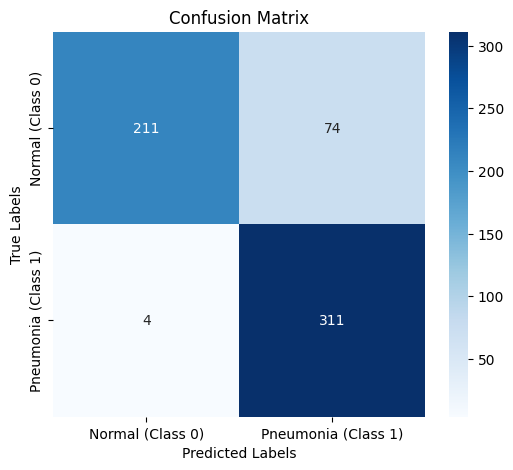

In [ ]:
# Generate confusion matrix
cm = confusion_matrix(cr_test_labels, test_preds)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Normal (Class 0)', 'Pneumonia (Class 1)'],
            yticklabels=['Normal (Class 0)', 'Pneumonia (Class 1)'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## Model Comparison Analysis

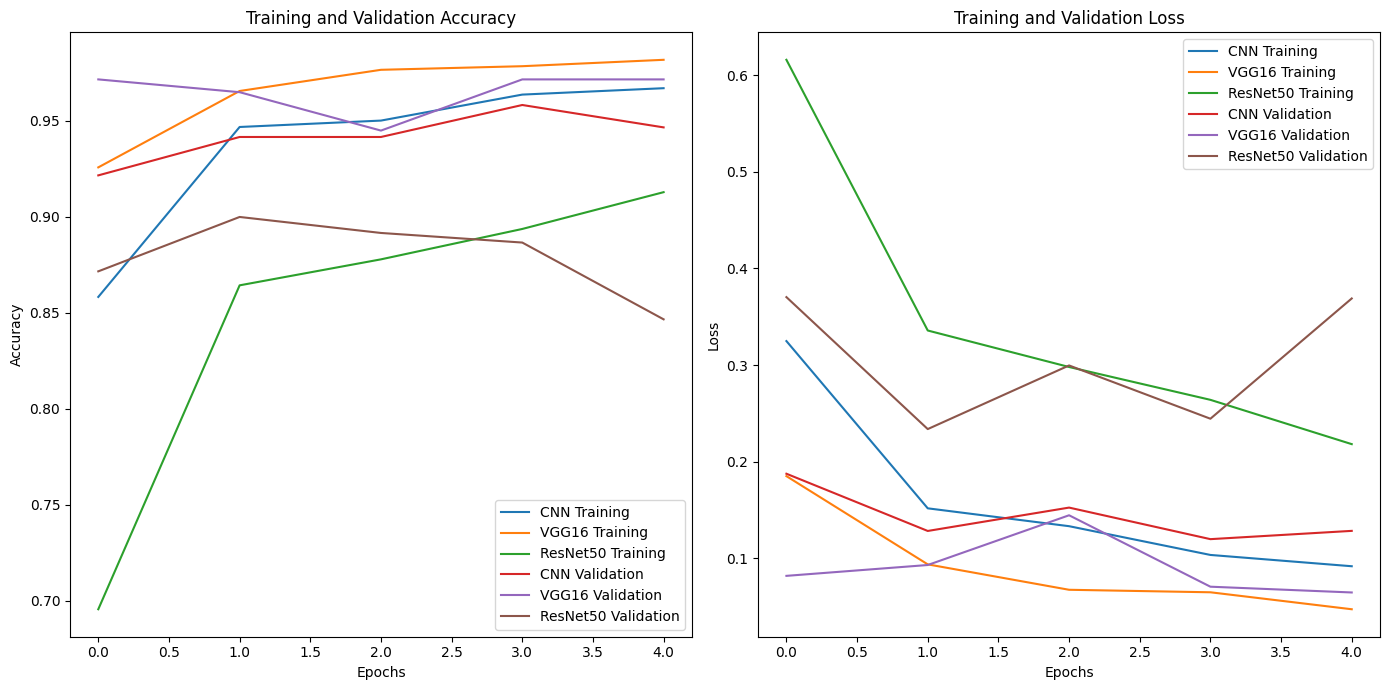

In [ ]:
# Performance comparison

fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Accuracy plot
axes[0].plot(loaded_cnn_history['accuracy'], label='CNN Training')
axes[0].plot(loaded_vgg16_history['accuracy'], label='VGG16 Training')
axes[0].plot(loaded_resnet50_history['accuracy'], label='ResNet50 Training')
axes[0].plot(loaded_cnn_history['val_accuracy'], label='CNN Validation')
axes[0].plot(loaded_vgg16_history['val_accuracy'], label='VGG16 Validation')
axes[0].plot(loaded_resnet50_history['val_accuracy'], label='ResNet50 Validation')
axes[0].set_title('Training and Validation Accuracy')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

# Loss plot
axes[1].plot(loaded_cnn_history['loss'], label='CNN Training')
axes[1].plot(loaded_vgg16_history['loss'], label='VGG16 Training')
axes[1].plot(loaded_resnet50_history['loss'], label='ResNet50 Training')
axes[1].plot(loaded_cnn_history['val_loss'], label='CNN Validation')
axes[1].plot(loaded_vgg16_history['val_loss'], label='VGG16 Validation')
axes[1].plot(loaded_resnet50_history['val_loss'], label='ResNet50 Validation')
axes[1].set_title('Training and Validation Loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()

# Display the comparison plots
plt.tight_layout()
plt.show()
